# DSC 475 Time Series Analysis and Forecasting
# Project 3.1
# Jingwen

### overview

In Project 3, you will create and train recurrent neural networks on real-world data. The goal is to train an RNN from scratch on a set of data containing over 20 thousand Last Names and their respective Country of Origin. The network should thus be able to predict the country of origin correctly based on a given last name by evaluating the sequence of characters in the given last name.  You will implement progressively complex training and testing/validation scenarios for RNNs. For Project 3.1 (this part), we will focus primarily on evaluating hyperparameters during training of the RNN. 

Script char_rnn_classification_Fall2020_example.py1 implements a vanilla RNN from scratch and trains it on a set of data containing over 20 thousand last names and their respective country of origin. The number of possible countries, or classes, is 18. All of the data for this project is in the file: data.zip. Each country of origin is contained in a separate file with the corresponding last names. A diagrammatic view of the structure of the implemented RNN is as follows:
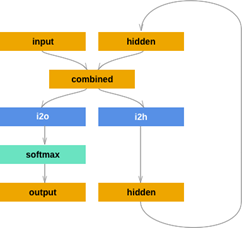
The architecture is such that the input (i.e. characters of the Last Name in this example) to the network is concatenated/stacked with the current hidden state to form a ‘combined’ stacked tensor (Refer to Lines 72-86 in the example code to see the structure of the tensors). The combined tensor is then fed through two different paths, i2h which updates the hidden state, and i2o which produces an output. Although outputs are produced at each time step, given that we are dealing with a classification task, only the output at the last time step is used.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

In [2]:
def findFiles(path): 
    return glob.glob(path)

#print(findFiles('C:/Users/Jingwen/Desktop/475 Time Series Analysis/作业/names/*.txt'))

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

In [4]:
names = {}
languages = []

In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [6]:
Number_names = 0

for filename in findFiles(r"C:/Users/Jingwen/Desktop/475 Time Series Analysis/作业/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines
    Number_names += len(names[category]) #total number of names

n_categories = len(languages)
print("there are total of", Number_names, "names" )

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''

#print(findName(names,'Johnson'))
#print(names['Italian'][:5])


there are total of 20074 names


###### Turning Names into Tensors

In [7]:
import torch

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [49]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [50]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [33]:
# Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 
    return tensor

#print(letterToTensor('J'))
#print(nameToTensor('Jones').size())
#print(nameToTensor('Jones'))

###### Creating the Network

In [11]:
import torch.nn as nn

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

###### Training

In [13]:
def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

#print(categoryFromOutput(output1))

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # For this example, we keep the learning rate fixed

In [16]:
def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [17]:
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [18]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [19]:
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

### 1. (25 points) Effect of hidden state length - run the script for hidden state sizes of 2, 8 and 32 by modifying the value of variable n_hidden. 

#### What is the Accuracy yielded for different hidden state sizes? Also, include a graph of the loss function and the confusion matrix for each case. 

Note that you will have to modify the existing evaluation function, as it measures accuracy from a randomly sampled population, which could lead to biased results:

    for i in range(n_confusion):
        category, name, category_tensor, name_tensor = randomTrainingExample()
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output) category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
        
You will want to measure performance on every sample in the dataset by comparing the label of the sample to the output of your trained network, and report the average accuracy.



In [20]:
n_iters = 100000
print_every = 5000
plot_every = 1000

hidden state size is 2: 


C:\Users\Jingwen\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  from ipykernel import kernelapp as app


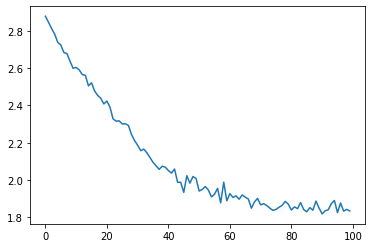

Accuracy is 0.451529


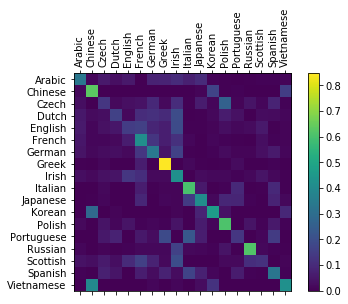

In [21]:
print("hidden state size is 2: ")
n_hidden = 2
rnn = RNN(n_letters, n_hidden, n_categories)

#-----------------------------------------------------------------------------------------------#
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)

for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
    
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

hidden state size is 8: 


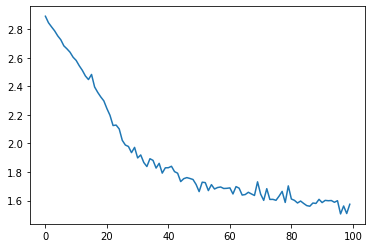

Accuracy is 0.502441


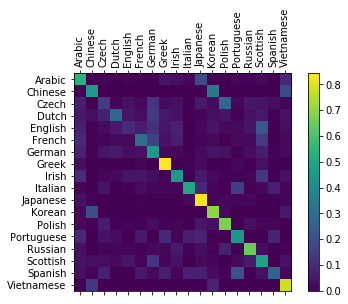

In [22]:
print("hidden state size is 8: ")
n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)

#-----------------------------------------------------------------------------------------------#

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)

for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
    
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

hidden state size is 32: 


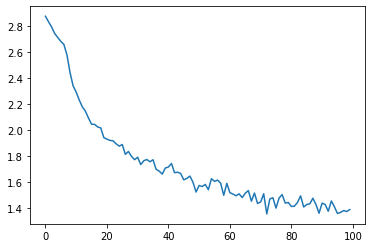

Accuracy is 0.579008


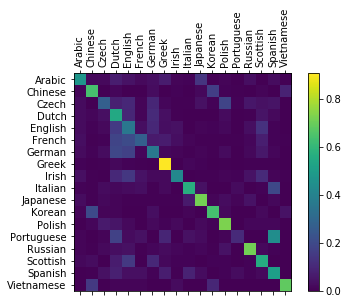

In [23]:
print("hidden state size is 32: ")
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

#-----------------------------------------------------------------------------------------------#

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)

for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
    
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### 2.	(15 points) Effect of systematic training - the script trains the network by going through 100 thousand data samples one by one in a random manner:

    for iter in range(1, n_iters + 1):
        category, name, category_tensor, name_tensor = randomTrainingExample()
        output, loss =train(category_tensor,name_tensor)
        current_loss += loss

The network parameters are updated by backpropagating losses computed on a per-sample basis. Also note that the there is only 1 training epoch in the example provided. 

Modify the script so that, instead of picking each training sample randomly, it goes through every available sample exactly once per training epoch. Randomize the order of the samples within each epoch. Train the network for five epochs, and report results as you change the hidden state size as in Problem 1 above.

Note that, since the dataset comprises around 20000 datapoints, the total number of data passes for this modified training process are like those required by problem 1. 

What is the accuracy yielded  by the algorithm thus trained and evaluated for the different values of hidden state size?  Also, include a graph of the loss function and the confusion matrix for each case. 


hidden state size is 2: 
Accuracy is 0.922685


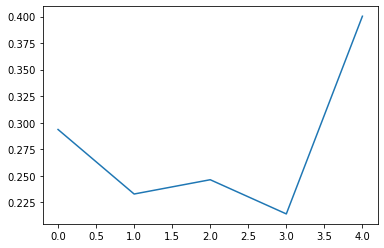

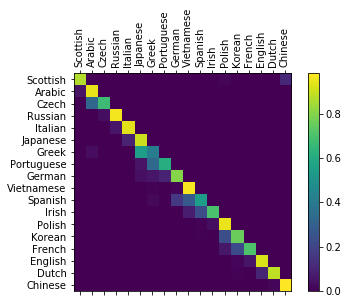

In [24]:
print("hidden state size is 2: ")
n_hidden = 2
rnn = RNN(n_letters, n_hidden, n_categories)

current_loss = 0
all_losses = []
n_epoch = 5

for r in range(n_epoch):
    random.shuffle(languages)
    for category in languages:
        random.shuffle(names[category])
        for name in names[category]:
            
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output, loss = train(category_tensor, name_tensor)
            current_loss += loss
            
            guess, guess_i = categoryFromOutput(output)
            category_i = languages.index(category)
            confusion[category_i][guess_i] += 1
            
    all_losses.append(current_loss/Number_names)
    current_loss = 0
                
#-----------------------------------------------------------------------------------------------#    
                
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

hidden state size is 8: 
Accuracy is 0.960798


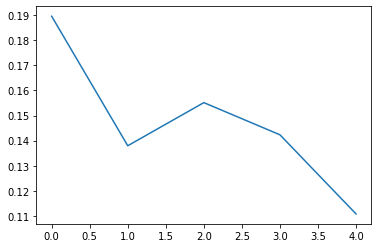

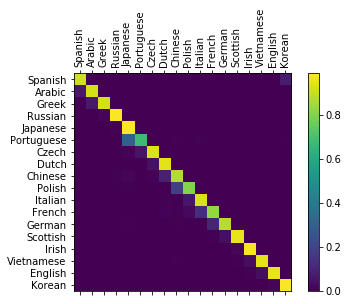

In [25]:
print("hidden state size is 8: ")
n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)

current_loss = 0
all_losses = []
n_epoch = 5

for r in range(n_epoch):
    random.shuffle(languages)
    for category in languages:
        random.shuffle(names[category])
        for name in names[category]:
            
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output, loss = train(category_tensor, name_tensor)
            current_loss += loss
            
            guess, guess_i = categoryFromOutput(output)
            category_i = languages.index(category)
            confusion[category_i][guess_i] += 1
            
    all_losses.append(current_loss/Number_names)
    current_loss = 0
                
#-----------------------------------------------------------------------------------------------#    
                
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

hidden state size is 32: 
Accuracy is 0.968198


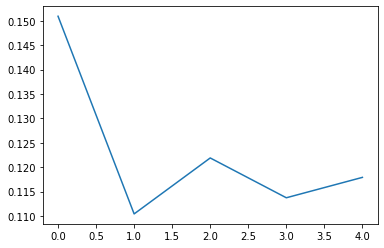

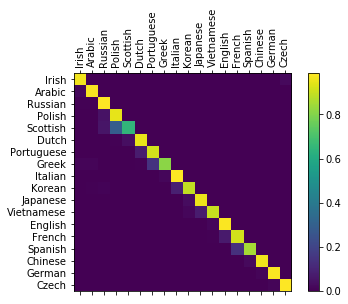

In [26]:
print("hidden state size is 32: ")
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

current_loss = 0
all_losses = []
n_epoch = 5
i=0

for r in range(n_epoch):
    random.shuffle(languages)
    for category in languages:
        random.shuffle(names[category])
        for name in names[category]:
            
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output, loss = train(category_tensor, name_tensor)
            current_loss += loss
        
            
            guess, guess_i = categoryFromOutput(output)
            category_i = languages.index(category)
            confusion[category_i][guess_i] += 1
            
    # Add current loss avg to list of losses
    all_losses.append(current_loss/Number_names)
    current_loss = 0
                
#-----------------------------------------------------------------------------------------------#    
                
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

#-----------------------------------------------------------------------------------------------#

plt.figure()
plt.plot(all_losses)
plt.show()

#-----------------------------------------------------------------------------------------------#

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()